In [9]:
import sys
from functools import partial
sys.path.append("../../")

import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ml_collections import ConfigDict


from sdebridge.sde import FourierGaussianKernelSDE
from sdebridge.diffusion_bridge import DiffusionBridge

## Unconditional process

In [10]:
def sample_ellipse(n_pts, scale, shifts=jnp.array([0.0, 0.0]), a=1.0, b=1.0):
    theta = jnp.linspace(0, 2 * jnp.pi, n_pts, endpoint=False)
    x = a * jnp.cos(theta)
    y = b * jnp.sin(theta)
    return scale * jnp.stack([x, y], axis=1) + shifts[None, :]

def reconstruct_trajectories(diff_coeffs_flatten_traj, initial_shape):
    diff_coeffs_traj = jnp.stack(
        jnp.split(diff_coeffs_flatten_traj, 2, axis=-1),
        axis=-1
    )
    n_pts = initial_shape.shape[-2]
    n_bases = diff_coeffs_traj.shape[-2]
    n_padding = (n_pts - n_bases) // 2
    diff_coeffs_traj_padded = jnp.pad(
        diff_coeffs_traj,
        ((0, 0), (0, 0), (n_padding, n_padding), (0, 0)),
        mode='constant',
        constant_values=0
    )
    diff_coeffs_traj_padded = jnp.fft.ifftshift(diff_coeffs_traj_padded, axes=-2)
    diff_traj_recon = jnp.fft.ifft(diff_coeffs_traj_padded, n=n_pts, axis=-2, norm='backward').real
    traj = diff_traj_recon + initial_shape[None, None, :, :]
    return traj

def plot_trajectories(traj, sample_idx, ax, cmap_name='viridis'):
    cmap = colormaps.get_cmap(cmap_name)
    colors = cmap(jnp.linspace(0, 1, traj.shape[-2]))
    for i in range(traj.shape[-2]):
        ax.scatter(traj[sample_idx, 0, i, 0], traj[sample_idx, 0, i, 1], color=colors[i], s=20, marker='o')
        ax.scatter(traj[sample_idx, -10, i, 0], traj[sample_idx, -10, i, 1], color=colors[i], s=20, marker='x')
        ax.plot(traj[sample_idx, :, i, 0], traj[sample_idx, :, i, 1], color=colors[i], alpha=0.3)
    return ax

def hidden_axes(fig, ax):
    fig.add_subplot(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    return ax

In [11]:
n_bases = 16
n_pts = 128
initial_shape = sample_ellipse(n_pts, 0.5)
initial_shape_ = sample_ellipse(2*n_pts, 0.5)
print(initial_shape.shape)

sde_config = ConfigDict(
    {
        'init_S': initial_shape,
        'n_bases': n_bases,
        'n_grid': n_bases,
        'grid_range': [-1.0, 1.0],
        'alpha': 1.0,
        'sigma': 0.2,
        'T': 1.0,
        'N': 50,
        'dim': 2
    }
)

unconditional_trajs = []
for n_bases in [8, 16, 24]:
    sde_config['n_bases'] = n_bases
    sde_config['n_grid'] = n_bases
    sde = FourierGaussianKernelSDE(sde_config)
    bridge = DiffusionBridge(sde)
    initial_diff_coeffs = jnp.zeros((n_bases, 2), dtype=jnp.complex64)
    initial_diff_flatten = jnp.concatenate(
        [initial_diff_coeffs[:, 0], initial_diff_coeffs[:, 1]],
        axis=0
    )
    forward_unconditional = bridge.simulate_forward_process(
        initial_val = initial_diff_flatten,
        num_batches = 1
    )
    forward_unconditional_diff_coeffs = forward_unconditional["trajectories"]
    forward_unconditional_traj = reconstruct_trajectories(
        forward_unconditional_diff_coeffs,
        initial_shape_,
    )
    unconditional_trajs.append(forward_unconditional_traj)

(128, 2)


Text(0.5, 0.98, 'Unconditional Forward Trajectories ($\\sigma=0.2$)')

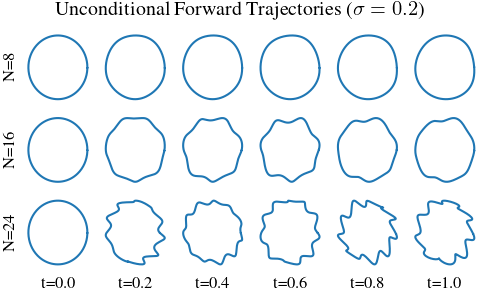

In [12]:
from sdebridge.plotting import set_style
from tueplots import figsizes

set_style()
plt.rcParams.update(figsizes.icml2024_half())

fig, ax = plt.subplots(3, 6)
for i in range(3):
    ax[i, 0].plot(unconditional_trajs[i][0, 0, :, 0], unconditional_trajs[i][0, 0, :, 1])
    hidden_axes(fig, ax[i, 0])
    for j in range(1, 6):
        ax[i, j].plot(unconditional_trajs[i][0, 10*j-1, :, 0], unconditional_trajs[i][0, 10*j-1, :, 1])
        hidden_axes(fig, ax[i, j])
for i in range(6):
    ax[2, i].set_xlabel(fr"t={i*0.2:.1f}")

for j in range(3):
    ax[j, 0].set_ylabel(fr"N={j*8+8}")

fig.suptitle(
    r"Unconditional Forward Trajectories ($\sigma=0.2$)",
)

In [13]:
fig.savefig("../figures/unconditional_trajs_different_n_bases.pdf", dpi=150)

In [14]:
unconditional_trajs = []
sde_config['n_bases'] = 16
sde_config['n_grid'] = 16
initial_diff_coeffs = jnp.zeros((16, 2), dtype=jnp.complex64)
initial_diff_flatten = jnp.concatenate(
    [initial_diff_coeffs[:, 0], initial_diff_coeffs[:, 1]],
    axis=0
)
for sigma in [0.1, 0.2, 0.3]:
    sde_config['sigma'] = sigma
    sde = FourierGaussianKernelSDE(sde_config)
    bridge = DiffusionBridge(sde)

    forward_unconditional = bridge.simulate_forward_process(
        initial_val = initial_diff_flatten,
        num_batches = 1
    )
    forward_unconditional_diff_coeffs = forward_unconditional["trajectories"]
    forward_unconditional_traj = reconstruct_trajectories(
        forward_unconditional_diff_coeffs,
        initial_shape_,
    )
    unconditional_trajs.append(forward_unconditional_traj)

Text(0.5, 0.98, 'Unconditional Forward Trajectories ($N=16$)')

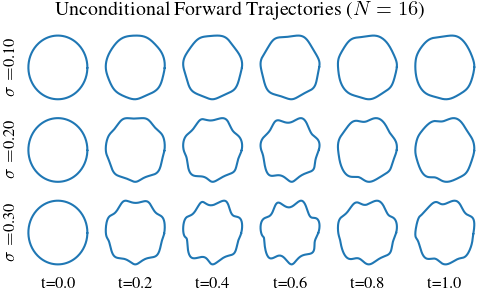

In [15]:
fig, ax = plt.subplots(3, 6)
for i in range(3):
    ax[i, 0].plot(unconditional_trajs[i][0, 0, :, 0], unconditional_trajs[i][0, 0, :, 1])
    hidden_axes(fig, ax[i, 0])
    for j in range(1, 6):
        ax[i, j].plot(unconditional_trajs[i][0, 10*j-1, :, 0], unconditional_trajs[i][0, 10*j-1, :, 1])
        hidden_axes(fig, ax[i, j])
for i in range(6):
    ax[2, i].set_xlabel(fr"t={i*0.2:.1f}")

for j in range(3):
    ax[j, 0].set_ylabel(fr"$\sigma=${j*0.1+0.1:.2f}")

fig.suptitle(r"Unconditional Forward Trajectories ($N=16$)")

In [115]:
fig.savefig("../figures/unconditional_trajs_different_sigma.pdf", dpi=150)

### Visualization of bridges

In [7]:
### load butterfly data
initial_butterfly = jnp.load('../data/tom_pts.npy')
target_butterfly = jnp.load('../data/honrathi_pts.npy')
print(initial_butterfly.shape, target_butterfly.shape)

(120, 2) (120, 2)


In [8]:
n_bases = 16
n_pts = initial_butterfly.shape[0]

sde_config = ConfigDict(
    {
        'init_S': initial_butterfly,
        'n_bases': n_bases,
        'n_grid': 64,
        'grid_range': [-1.5, 1.5],
        'alpha': 1.0,
        'sigma': 0.1,
        'T': 1.0,
        'N': 50,
        'dim': 2
    }
)

sde = FourierGaussianKernelSDE(sde_config)
bridge = DiffusionBridge(sde)

initial_diff_coeffs = jnp.zeros((n_bases, 2), dtype=jnp.complex64)

target_diff = target_butterfly - initial_butterfly
target_diff_coeffs = jnp.fft.fft(target_diff, n=n_pts, axis=0, norm='backward')
target_diff_coeffs = jnp.fft.fftshift(target_diff_coeffs, axes=0)   # shift zero freqency to center for truncation
print("untruncated target_diff_coeffs.shape", target_diff_coeffs.shape)
target_diff_coeffs = target_diff_coeffs[
    (n_pts - n_bases) // 2: (n_pts + n_bases) // 2, :
]   # truncate low frequencies
print("initial_diff_coeffs.shape", initial_diff_coeffs.shape)
print("target_diff_coeffs.shape", target_diff_coeffs.shape)

initial_diff_flatten = jnp.concatenate(
    [initial_diff_coeffs[:, 0], initial_diff_coeffs[:, 1]],
    axis=0
)
target_diff_flatten = jnp.concatenate(
    [target_diff_coeffs[:, 0], target_diff_coeffs[:, 1]],
    axis=0
)
print("initial_diff_flatten.shape", initial_diff_flatten.shape)
print("target_diff_flatten.shape", target_diff_flatten.shape)

untruncated target_diff_coeffs.shape (120, 2)
initial_diff_coeffs.shape (16, 2)
target_diff_coeffs.shape (16, 2)
initial_diff_flatten.shape (32,)
target_diff_flatten.shape (32,)


In [9]:
from sdebridge.networks import ScoreUNet
from sdebridge.utils import create_train_state
import orbax.checkpoint

In [10]:
def reconstruct_trajectories(diff_coeffs_flatten_traj, initial_butterfly):
    diff_coeffs_traj = jnp.stack(
        jnp.split(diff_coeffs_flatten_traj, 2, axis=-1),
        axis=-1
    )
    diff_coeffs_traj_padded = jnp.pad(
        diff_coeffs_traj,
        ((0, 0), (0, 0), (sde.n_padding, sde.n_padding), (0, 0)),
        mode='constant',
        constant_values=0
    )
    diff_coeffs_traj_padded = jnp.fft.ifftshift(diff_coeffs_traj_padded, axes=-2)
    diff_traj_recon = jnp.fft.ifft(diff_coeffs_traj_padded, n=n_pts, axis=-2, norm='backward').real
    traj = diff_traj_recon + initial_butterfly[None, None, :, :]
    return traj

def load_ckpts(ckpt_path):
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    ckpt_dict = orbax_checkpointer.restore(ckpt_path)
    network_config = ckpt_dict["training_config"]["network"]
    new_state = create_train_state(
        model=ScoreUNet(**network_config),
        rng_key=jax.random.PRNGKey(0),
        input_shapes=((1, 2*sde_config.dim*sde_config.n_bases), (1, 1)),
        learning_rate=0.01,
        warmup_steps=1,
        decay_steps=10
    )
    traget = {
        "state": new_state,
        "training_config": {},
    }
    ckpt = orbax_checkpointer.restore(ckpt_path, item=traget)
    return ckpt["state"]

In [11]:
fig.savefig("../figures/unconditional_trajs_different_sigma.pdf", dpi=150)

### Covariance matrices

In [21]:
def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, alpha: float, sigma: float) -> jnp.ndarray:
    return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))

def landmark_covariance(lmks_diff, init_shape, alpha, sigma, n_grid):
    n_pts = init_shape.shape[0]
    grid = jnp.linspace(-1.0, 1.0, n_grid)
    grid = jnp.stack(jnp.meshgrid(grid, grid, indexing='xy'), axis=-1)
    curr_shape = init_shape + lmks_diff
    Q = jax.vmap(
        jax.vmap(
            jax.vmap(
                partial(gaussian_kernel_2d, alpha=alpha, sigma=sigma),
                in_axes=(None, 0),
                out_axes=0
            ),
            in_axes=(None, 1),
            out_axes=1
        ),
        in_axes=(0, None),
        out_axes=0
    )(curr_shape, grid)
    Q = Q.reshape(n_pts, n_grid**2)
    return jnp.matmul(Q, Q.T)

def coefficient_covariance(coeffs_diff, init_shape, alpha, sigma, n_grid):
    n_pts = init_shape.shape[0]
    n_bases = coeffs_diff.shape[0]
    n_padding = (n_pts - n_bases) // 2
    grid = jnp.linspace(-1.0, 1.0, n_grid)
    grid = jnp.stack(jnp.meshgrid(grid, grid, indexing='xy'), axis=-1)

    base_fn = lambda freq: jnp.exp(1j * jnp.arange(-n_pts//2, n_pts//2) * freq)
    freqs = jnp.fft.fftshift(
        jnp.fft.fftfreq(n_bases, d=1/(2.0*jnp.pi))
    )
    basis = jax.vmap(base_fn)(freqs)

    def eval_coeffs(coeffs):
        coeffs = coeffs / jnp.sqrt(n_pts)
        coeffs = jnp.pad(coeffs, ((n_padding, n_padding), (0, 0)))
        return jnp.matmul(basis, coeffs) / jnp.sqrt(n_pts)
    
    def eval_shape(shape):
        shape_coeffs = jnp.fft.fft(shape, n=n_pts, axis=0) / jnp.sqrt(n_pts)
        shape_coeffs = jnp.fft.fftshift(shape_coeffs, axes=0)
        return jnp.matmul(basis, shape_coeffs) / jnp.sqrt(n_pts)
    
    init_shape_eval = eval_shape(init_shape)
    coeffs_eval = eval_coeffs(coeffs_diff)
    curr_shape_eval = init_shape_eval + coeffs_eval

    Q = jax.vmap(
        jax.vmap(
            jax.vmap(
                partial(gaussian_kernel_2d, alpha=alpha, sigma=sigma),
                in_axes=(None, 0),
                out_axes=0
            ),
            in_axes=(None, 1),
            out_axes=1
        ),
        in_axes=(0, None),
        out_axes=0
    )(curr_shape_eval, grid)
    Q = Q.reshape(n_bases, n_grid**2)
    return jnp.matmul(Q, Q.T)

In [22]:
diff = target_butterfly - initial_butterfly
lmk_cov = landmark_covariance(diff[::2, :], initial_butterfly[::2, :], 1.0, 0.2, 64)

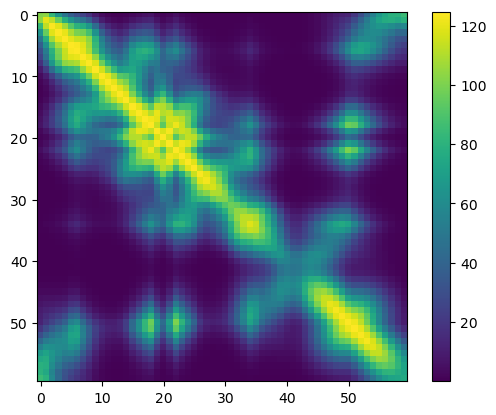

In [23]:
plt.imshow(lmk_cov)
plt.colorbar()

In [24]:
diff_coeff = jnp.fft.fft(diff, axis=0)
diff_coeff = jnp.fft.fftshift(diff_coeff, axes=0)
diff_coeff = diff_coeff[(diff_coeff.shape[0] - 60) // 2 : (diff_coeff.shape[0] + 60) // 2, :]
coeff_cov = coefficient_covariance(diff_coeff, initial_butterfly, 1.0, 0.2, 64)

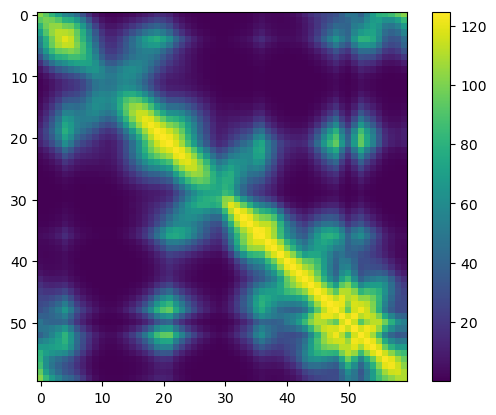

In [25]:
plt.imshow(coeff_cov)
plt.colorbar()

### Score evolution

In [16]:
@partial(jax.jit, backend='gpu')
def inference_score_coeffs(X_coeffs, time, state):
    score_output = state.apply_fn(
        {"params": state.params, "batch_stats": state.batch_stats},
        x_complex=X_coeffs,
        t=time,
        train=False
    )
    score_real, score_imag = jnp.split(score_output, 2, axis=-1)
    score_coeffs = score_real + 1j * score_imag
    return score_coeffs

def evaluate_score(score_coeffs, n_pts):
    n_bases = score_coeffs.shape[0]
    n_padding = (n_pts - n_bases) // 2

    score_coeffs = jnp.pad(score_coeffs, ((n_padding, n_padding), (0, 0)))
    score_coeffs = jnp.fft.ifftshift(score_coeffs, axes=0)
    score_eval = jnp.fft.ifft(score_coeffs, n=n_pts, axis=0, norm='backward').real
    return score_eval

def simulate(state, n_bases, initial_shape, target_shape):
    n_pts = initial_shape.shape[0]

    sde_config = ConfigDict(
        {
            'init_S': initial_shape,
            'n_bases': n_bases,
            'n_grid': 64,
            'grid_range': [-1.5, 1.5],
            'alpha': 1.0,
            'sigma': 0.1,
            'T': 1.0,
            'N': 50,
            'dim': 2
        }
    )

    sde = FourierGaussianKernelSDE(sde_config)
    bridge = DiffusionBridge(sde)

    initial_diff_coeffs = jnp.zeros((n_bases, 2), dtype=jnp.complex64)
    target_diff = target_shape - initial_shape
    target_diff_coeffs = jnp.fft.fft(target_diff, n=n_pts, axis=0, norm='backward')
    target_diff_coeffs = jnp.fft.fftshift(target_diff_coeffs, axes=0)   # shift zero freqency to center for truncation
    target_diff_coeffs = target_diff_coeffs[
        (n_pts - n_bases) // 2: (n_pts + n_bases) // 2, :
    ]   # truncate low frequencies

    initial_diff_flatten = jnp.concatenate(
        [initial_diff_coeffs[:, 0], initial_diff_coeffs[:, 1]],
        axis=0
    )
    target_diff_flatten = jnp.concatenate(
        [target_diff_coeffs[:, 0], target_diff_coeffs[:, 1]],
        axis=0
    )

    score_p = lambda val, time: partial(inference_score_coeffs, state=state)(val, time)
    backward_X_coeffs_bridge = bridge.simulate_backward_bridge(
        initial_val=initial_diff_flatten,
        terminal_val=target_diff_flatten,
        score_p=score_p,
        num_batches=1,
    )
    
    backward_X_coeffs_bridge_traj = backward_X_coeffs_bridge["trajectories"]
    backward_traj = reconstruct_trajectories(
        backward_X_coeffs_bridge_traj,
        initial_shape
    )

    score_evals = []
    for i in range(6):
        score_coeffs = inference_score_coeffs(backward_X_coeffs_bridge_traj[0, i*10, :], jnp.array([i*0.2]), state)
        score_coeffs = jnp.squeeze(score_coeffs)
        score_coeffs = jnp.stack(jnp.split(score_coeffs, 2, axis=-1), axis=-1)
        score_eval = evaluate_score(score_coeffs, initial_shape.shape[0])
        score_evals.append(score_eval)
    score_evals = jnp.stack(score_evals, axis=0)
    return backward_traj, score_evals

In [17]:
score_p_state_8 = load_ckpts('/home/gefan/Projects/sdebridge/sdebridge/ckpts/score_p_8_bases')
score_p_state_16 = load_ckpts('/home/gefan/Projects/sdebridge/sdebridge/ckpts/score_p_16_bases')
score_p_state_24 = load_ckpts('/home/gefan/Projects/sdebridge/sdebridge/ckpts/score_p_24_bases_retrain')

In [18]:
backward_bridge_traj_8, score_evals_8 = simulate(score_p_state_8, 8, initial_butterfly, target_butterfly)
backward_bridge_traj_16, score_evals_16 = simulate(score_p_state_16, 16, initial_butterfly, target_butterfly)
backward_bridge_traj_24, score_evals_24 = simulate(score_p_state_24, 24, initial_butterfly, target_butterfly)

In [19]:
print(backward_bridge_traj_8.shape, score_evals_8.shape)
print(backward_bridge_traj_16.shape, score_evals_16.shape)
print(backward_bridge_traj_24.shape, score_evals_24.shape)

(1, 50, 120, 2) (6, 120, 2)
(1, 50, 120, 2) (6, 120, 2)
(1, 50, 120, 2) (6, 120, 2)


Text(0, 0.5, 'N=24')

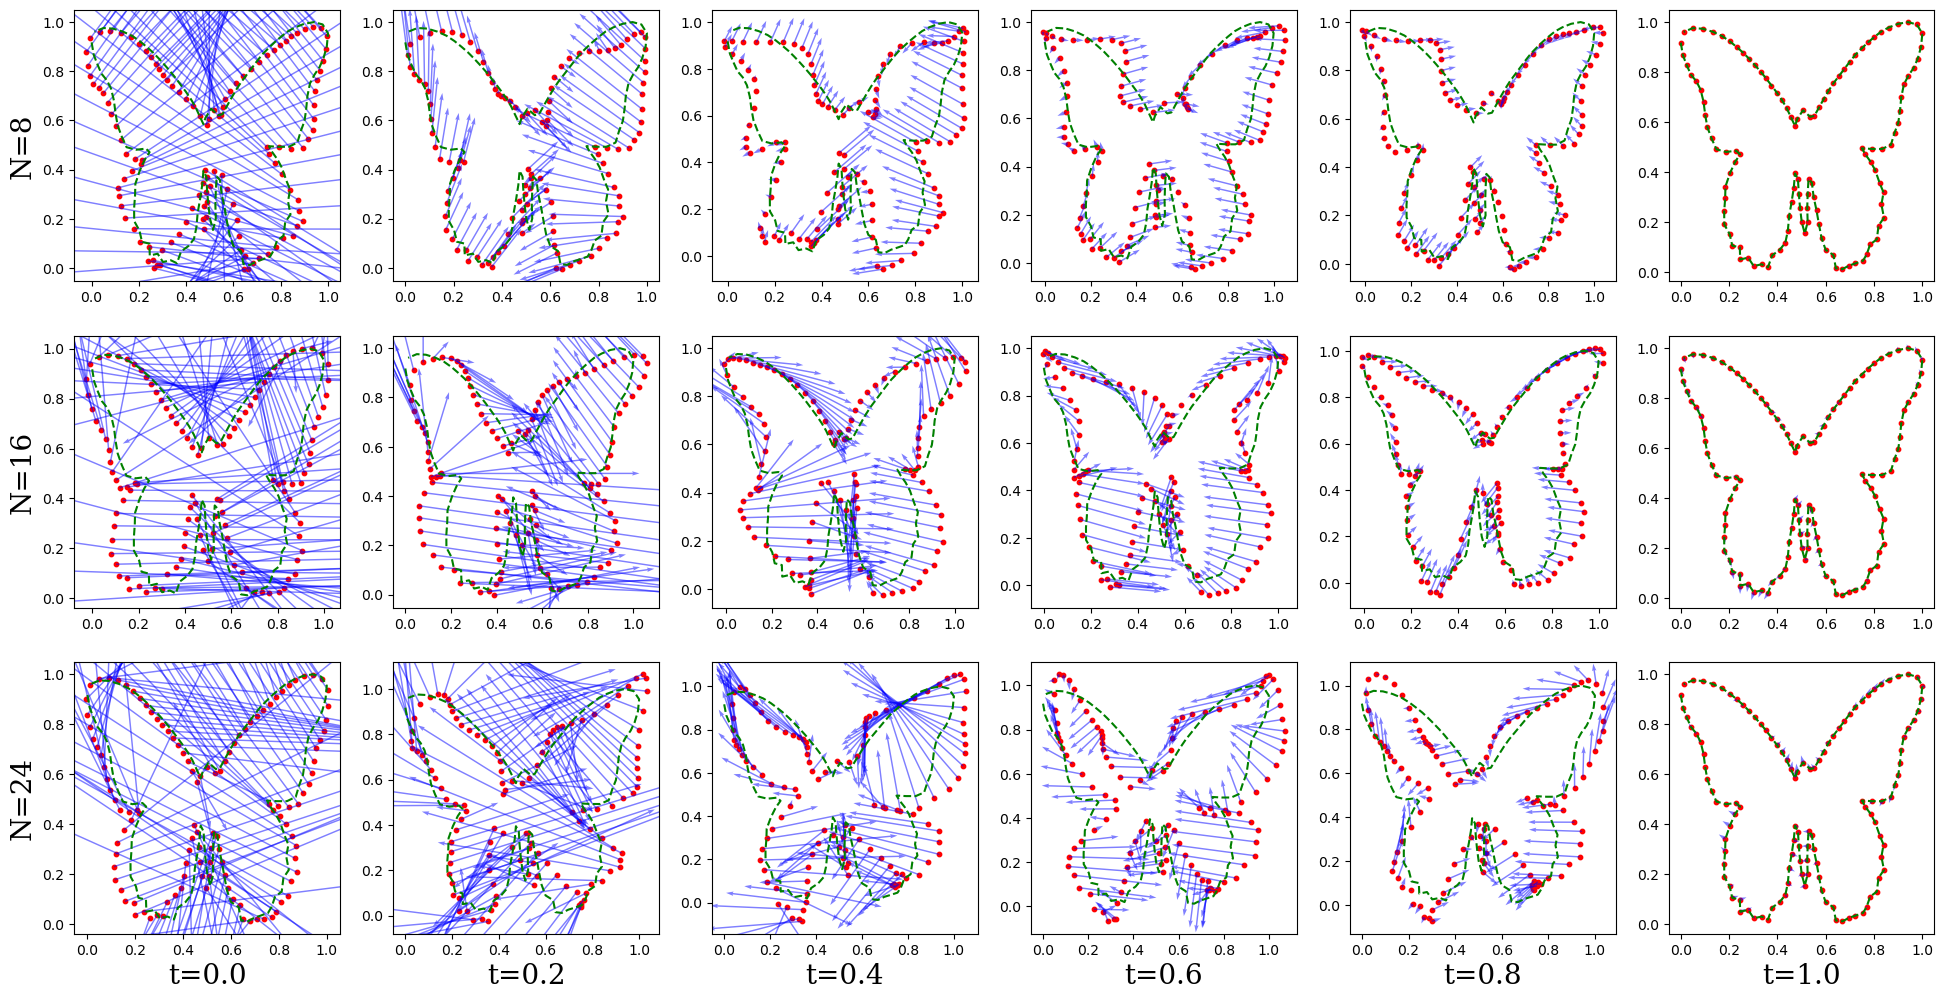

In [26]:
fig, ax = plt.subplots(3, 6, figsize=(24, 12))
for i in range(6):
    ax[0, i].scatter(backward_bridge_traj_8[0, i*10, :, 0], backward_bridge_traj_8[0, i*10, :, 1], color='r', marker='o', s=10)
    ax[0, i].quiver(
        backward_bridge_traj_8[0, i*10, :, 0],
        backward_bridge_traj_8[0, i*10, :, 1],
        score_evals_8[i, :, 0],
        score_evals_8[i, :, 1],
        color='b',
        alpha=0.5,
        scale=0.1,
        angles='xy'
    )
    ax[0, i].plot(backward_bridge_traj_8[0, -1, :, 0], backward_bridge_traj_8[0, -1, :, 1], color='g', linestyle='--')

    ax[1, i].scatter(backward_bridge_traj_16[0, i*10, :, 0], backward_bridge_traj_16[0, i*10, :, 1], color='r', marker='o', s=10)
    ax[1, i].quiver(
        backward_bridge_traj_16[0, i*10, :, 0],
        backward_bridge_traj_16[0, i*10, :, 1],
        score_evals_16[i, :, 0],
        score_evals_16[i, :, 1],
        color='b',
        alpha=0.5,
        scale=0.1,
        angles='xy'
    )
    ax[1, i].plot(backward_bridge_traj_16[0, -1, :, 0], backward_bridge_traj_16[0, -1, :, 1], color='g', linestyle='--')

    ax[2, i].scatter(backward_bridge_traj_24[0, i*10, :, 0], backward_bridge_traj_24[0, i*10, :, 1], color='r', marker='o', s=10)
    ax[2, i].quiver(
        backward_bridge_traj_24[0, i*10, :, 0],
        backward_bridge_traj_24[0, i*10, :, 1],
        score_evals_24[i, :, 0],
        score_evals_24[i, :, 1],
        color='b',
        alpha=0.5,
        scale=0.1,
        angles='xy'
    )
    ax[2, i].plot(backward_bridge_traj_24[0, -1, :, 0], backward_bridge_traj_24[0, -1, :, 1], color='g', linestyle='--')

    ax[2, i].set_xlabel(fr"t={i*0.2:.1f}", fontsize=20, fontfamily='serif')

ax[0, 0].set_ylabel(fr"N=8", fontsize=20, fontfamily='serif')
ax[1, 0].set_ylabel(fr"N=16", fontsize=20, fontfamily='serif')
ax[2, 0].set_ylabel(fr"N=24", fontsize=20, fontfamily='serif')

# fig.savefig("../figures/score_visualization.png", dpi=100, bbox_inches='tight')